# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

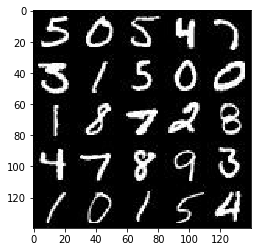

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [4]:
mnist_images.shape

(25, 28, 28, 1)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

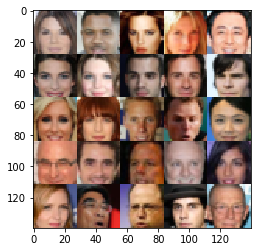

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [71]:
def discriminator(images, reuse=False, size_mult=64, alpha=0.2, training=True, drop_rate=0.):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, size_mult, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        ##14x14xsize_mult
        
        x2 = tf.layers.conv2d(relu1, size_mult * 2, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=training)
        relu2 = tf.maximum(alpha * bn2, bn2)
        ##7x7x2size_mult
        
        x3 = tf.layers.conv2d(relu2, size_mult * 2, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=training)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        ##4x4x4size_mult
        
        x4 = tf.layers.conv2d(relu3, size_mult * 4, 4, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=training)
        relu4 = tf.maximum(alpha * bn4, bn4)
        ##4x4x4size_mult
        
        flatten_shape = relu4.get_shape().as_list()[1]*relu4.get_shape().as_list()[2]*relu4.get_shape().as_list()[3]
        flat = tf.reshape(relu4, [-1, flatten_shape])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True, size_mult=64, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4 * 4 * size_mult * 8)
        
        x1 = tf.reshape(x1, [-1, 4, 4, size_mult * 8])
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #4x4x6size_mult
        
        x2 = tf.layers.conv2d_transpose(relu1, size_mult * 4, 4, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x4size_mult
        
        x3 = tf.layers.conv2d_transpose(relu2, size_mult * 2, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #14x14x2size_mult
        
        x4 = tf.layers.conv2d_transpose(relu3, out_channel_dim, 4, strides=2, padding='same')
        #28x28x3
        logits = x4
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [73]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, drop_rate=0., size_mult=64, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, size_mult=size_mult, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, size_mult=size_mult, 
                                                alpha=alpha, training=True, drop_rate=drop_rate)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, size_mult=size_mult, 
                                                alpha=alpha, training=True, drop_rate=drop_rate)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [74]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [82]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, size_mult=size_mult, alpha=alpha):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False, size_mult=size_mult, alpha=alpha),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [86]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          alpha=0.2, drop_rate=0., size_mult=64, smooth=0.1):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 100
    
    
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[-1], 
                                alpha=alpha, drop_rate=drop_rate, size_mult=size_mult, smooth=smooth)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    losses = []
    steps = 0
    start_training_time = time.time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                start_time = time.time()
                steps +=1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, 
                                                     z_input: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_input: batch_images, 
                                                     z_input: batch_z,
                                                     lr: learning_rate})
                if steps % 10 == 0:
                    d_train_loss = d_loss.eval({real_input: batch_images,
                                                z_input: batch_z})
                    g_train_loss = g_loss.eval({z_input: batch_z})
                    
                    losses.append((d_train_loss, g_train_loss))
                    
                    if steps % print_every == 0:
                    
                        print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                              "Discriminator Loss: {:.4f}...".format(d_train_loss),
                              "Generator Loss: {:.4f}".format(g_train_loss),
                              "Time spent: {:.4f}".format(time.time() - start_time))   

                    
                    
                if steps % (print_every * 2) == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode, size_mult=size_mult, alpha=alpha)

        saver.save(sess, './checkpoints/generator.ckpt')
    
    print ("Total Training Time: {:.4f}".format(time.time() - start_training_time))
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 100... Discriminator Loss: 1.6232... Generator Loss: 1.9339 Time spent: 0.5916
Epoch 1/2 Step 200... Discriminator Loss: 1.1102... Generator Loss: 2.1397 Time spent: 0.5798


Epoch 1/2 Step 300... Discriminator Loss: 1.0952... Generator Loss: 2.3337 Time spent: 0.5802
Epoch 1/2 Step 400... Discriminator Loss: 0.8389... Generator Loss: 1.6203 Time spent: 0.5792


Epoch 1/2 Step 500... Discriminator Loss: 1.0262... Generator Loss: 2.0562 Time spent: 0.5764
Epoch 1/2 Step 600... Discriminator Loss: 1.0874... Generator Loss: 0.7290 Time spent: 0.5758


Epoch 2/2 Step 700... Discriminator Loss: 1.1117... Generator Loss: 2.3681 Time spent: 0.5884
Epoch 2/2 Step 800... Discriminator Loss: 0.7896... Generator Loss: 1.5689 Time spent: 0.5687


Epoch 2/2 Step 900... Discriminator Loss: 0.9754... Generator Loss: 2.0971 Time spent: 0.5718
Epoch 2/2 Step 1000... Discriminator Loss: 0.7402... Generator Loss: 1.4224 Time spent: 0.5830


Epoch 2/2 Step 1100... Discriminator Loss: 0.8446... Generator Loss: 1.0614 Time spent: 0.5731
Epoch 2/2 Step 1200... Discriminator Loss: 1.0131... Generator Loss: 0.8435 Time spent: 0.5817


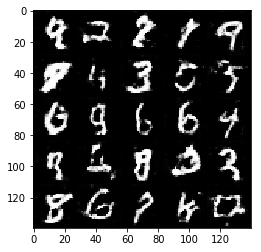

Total Training Time: 514.9337


In [87]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2

alpha = 0.2
drop_rate = 0.5
size_mult = 128
smooth = 0.1

tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
                   mnist_dataset.shape, mnist_dataset.image_mode, 
                   alpha=alpha, drop_rate=drop_rate, size_mult=size_mult, smooth=smooth)

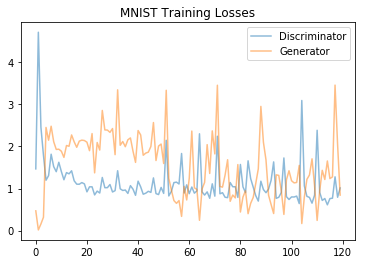

In [90]:
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
pyplot.title("MNIST Training Losses")
pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10 Step 100... Discriminator Loss: 0.5857... Generator Loss: 2.8437 Time spent: 1.0919
Epoch 1/10 Step 200... Discriminator Loss: 0.7215... Generator Loss: 1.4765 Time spent: 1.1016


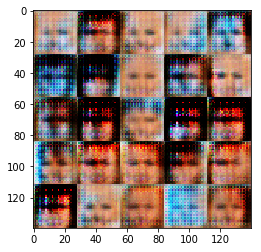

Epoch 1/10 Step 300... Discriminator Loss: 0.7896... Generator Loss: 1.9732 Time spent: 1.1041
Epoch 1/10 Step 400... Discriminator Loss: 0.7947... Generator Loss: 1.3304 Time spent: 1.1052


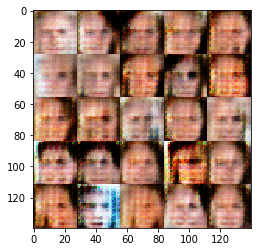

Epoch 1/10 Step 500... Discriminator Loss: 1.1479... Generator Loss: 1.0748 Time spent: 1.1002
Epoch 1/10 Step 600... Discriminator Loss: 1.1724... Generator Loss: 1.4295 Time spent: 1.1001


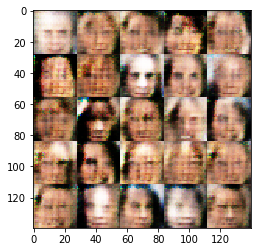

Epoch 1/10 Step 700... Discriminator Loss: 1.4375... Generator Loss: 0.6661 Time spent: 1.1015
Epoch 1/10 Step 800... Discriminator Loss: 2.6752... Generator Loss: 4.0422 Time spent: 1.1016


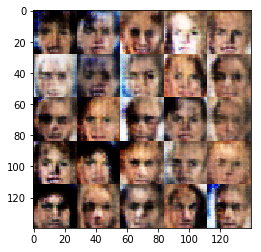

Epoch 1/10 Step 900... Discriminator Loss: 1.2374... Generator Loss: 0.8253 Time spent: 1.1041
Epoch 1/10 Step 1000... Discriminator Loss: 1.1852... Generator Loss: 1.7864 Time spent: 1.0980


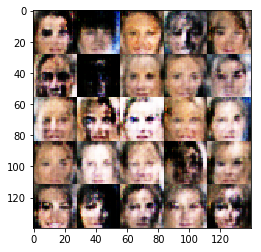

Epoch 2/10 Step 1100... Discriminator Loss: 0.9641... Generator Loss: 1.0242 Time spent: 1.1007
Epoch 2/10 Step 1200... Discriminator Loss: 1.4990... Generator Loss: 0.4555 Time spent: 1.1022


Epoch 2/10 Step 1300... Discriminator Loss: 1.1260... Generator Loss: 1.1281 Time spent: 1.1064
Epoch 2/10 Step 1400... Discriminator Loss: 1.5634... Generator Loss: 0.9008 Time spent: 1.1076


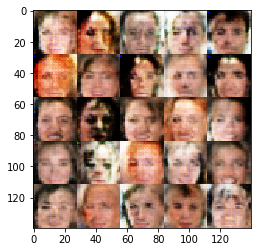

Epoch 2/10 Step 1500... Discriminator Loss: 1.8784... Generator Loss: 0.3129 Time spent: 1.1018
Epoch 2/10 Step 1600... Discriminator Loss: 1.0786... Generator Loss: 1.1750 Time spent: 1.0926


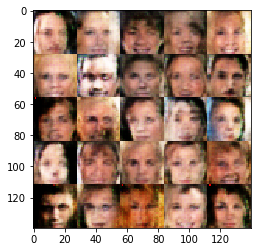

Epoch 2/10 Step 1700... Discriminator Loss: 1.1185... Generator Loss: 0.8556 Time spent: 1.1032
Epoch 2/10 Step 1800... Discriminator Loss: 0.8808... Generator Loss: 1.1809 Time spent: 1.0917


Epoch 2/10 Step 1900... Discriminator Loss: 1.1598... Generator Loss: 2.6150 Time spent: 1.0990
Epoch 2/10 Step 2000... Discriminator Loss: 1.0763... Generator Loss: 0.7949 Time spent: 1.1084


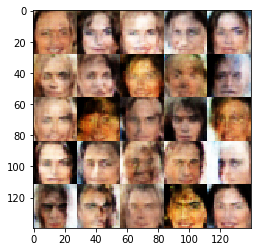

Epoch 3/10 Step 2100... Discriminator Loss: 1.0280... Generator Loss: 1.1050 Time spent: 1.0927
Epoch 3/10 Step 2200... Discriminator Loss: 0.7576... Generator Loss: 1.3742 Time spent: 1.1083


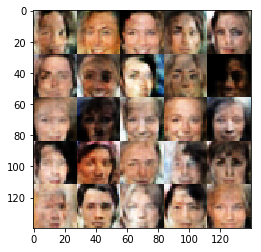

Epoch 3/10 Step 2300... Discriminator Loss: 0.9930... Generator Loss: 1.1425 Time spent: 1.0956
Epoch 3/10 Step 2400... Discriminator Loss: 0.9798... Generator Loss: 1.2586 Time spent: 1.0972


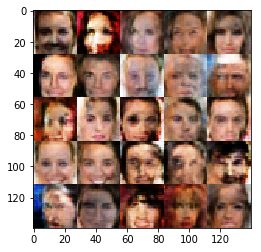

Epoch 3/10 Step 2500... Discriminator Loss: 0.7939... Generator Loss: 1.1827 Time spent: 1.0995
Epoch 3/10 Step 2600... Discriminator Loss: 0.7918... Generator Loss: 1.1484 Time spent: 1.1017


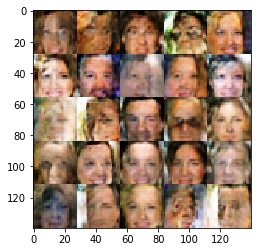

Epoch 3/10 Step 2700... Discriminator Loss: 0.6548... Generator Loss: 2.8360 Time spent: 1.1019
Epoch 3/10 Step 2800... Discriminator Loss: 0.9407... Generator Loss: 1.2367 Time spent: 1.0955


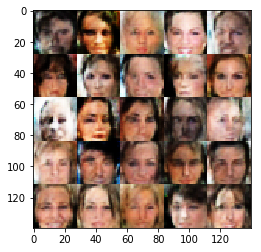

Epoch 3/10 Step 2900... Discriminator Loss: 1.1763... Generator Loss: 0.7083 Time spent: 1.1031
Epoch 3/10 Step 3000... Discriminator Loss: 3.0681... Generator Loss: 0.1434 Time spent: 1.1069


Epoch 4/10 Step 3100... Discriminator Loss: 1.5582... Generator Loss: 0.4657 Time spent: 1.0976
Epoch 4/10 Step 3200... Discriminator Loss: 0.6759... Generator Loss: 1.8202 Time spent: 1.0999


Epoch 4/10 Step 3300... Discriminator Loss: 1.0616... Generator Loss: 0.8793 Time spent: 1.1091
Epoch 4/10 Step 3400... Discriminator Loss: 1.0970... Generator Loss: 0.7964 Time spent: 1.0955


Epoch 4/10 Step 3500... Discriminator Loss: 1.0933... Generator Loss: 1.2393 Time spent: 1.1034
Epoch 4/10 Step 3600... Discriminator Loss: 0.5031... Generator Loss: 2.3544 Time spent: 1.0965


Epoch 4/10 Step 3700... Discriminator Loss: 0.5636... Generator Loss: 1.9021 Time spent: 1.0987
Epoch 4/10 Step 3800... Discriminator Loss: 1.0090... Generator Loss: 1.0937 Time spent: 1.1033


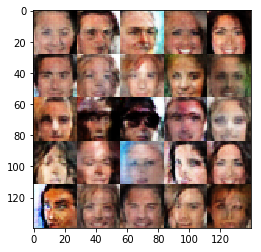

Epoch 4/10 Step 3900... Discriminator Loss: 1.0306... Generator Loss: 0.9260 Time spent: 1.0986
Epoch 4/10 Step 4000... Discriminator Loss: 0.5191... Generator Loss: 2.2569 Time spent: 1.0959


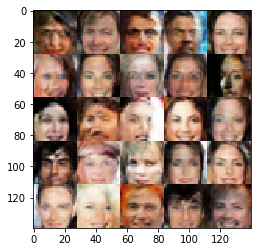

Epoch 5/10 Step 4100... Discriminator Loss: 0.3907... Generator Loss: 3.5662 Time spent: 1.0935
Epoch 5/10 Step 4200... Discriminator Loss: 0.9203... Generator Loss: 2.1874 Time spent: 1.0992


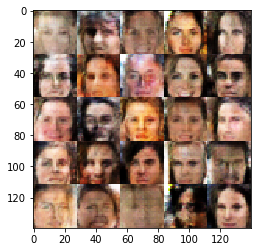

Epoch 5/10 Step 4300... Discriminator Loss: 0.6813... Generator Loss: 1.5606 Time spent: 1.0970
Epoch 5/10 Step 4400... Discriminator Loss: 0.5726... Generator Loss: 4.7358 Time spent: 1.1006


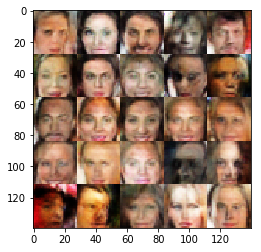

Epoch 5/10 Step 4500... Discriminator Loss: 0.9865... Generator Loss: 0.9316 Time spent: 1.1014
Epoch 5/10 Step 4600... Discriminator Loss: 0.4534... Generator Loss: 3.0358 Time spent: 1.0913


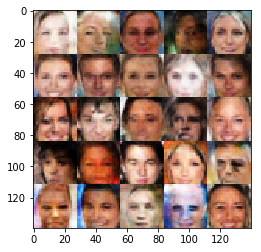

Epoch 5/10 Step 4700... Discriminator Loss: 1.3327... Generator Loss: 0.7970 Time spent: 1.0904
Epoch 5/10 Step 4800... Discriminator Loss: 0.4908... Generator Loss: 3.7236 Time spent: 1.1015


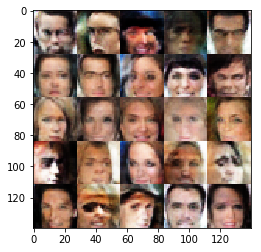

Epoch 5/10 Step 4900... Discriminator Loss: 0.8695... Generator Loss: 1.2198 Time spent: 1.1065
Epoch 5/10 Step 5000... Discriminator Loss: 0.9509... Generator Loss: 2.8232 Time spent: 1.0997


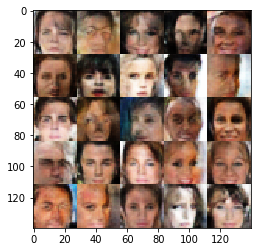

Epoch 6/10 Step 5100... Discriminator Loss: 0.7865... Generator Loss: 1.8828 Time spent: 1.0872
Epoch 6/10 Step 5200... Discriminator Loss: 0.7625... Generator Loss: 1.4811 Time spent: 1.1063


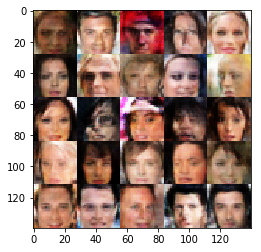

Epoch 6/10 Step 5300... Discriminator Loss: 1.0148... Generator Loss: 0.9445 Time spent: 1.0999
Epoch 6/10 Step 5400... Discriminator Loss: 0.5289... Generator Loss: 2.4387 Time spent: 1.0965


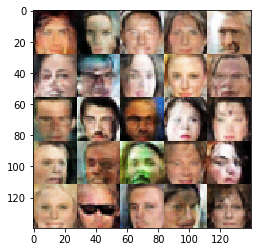

Epoch 6/10 Step 5500... Discriminator Loss: 0.5555... Generator Loss: 1.9618 Time spent: 1.0884
Epoch 6/10 Step 5600... Discriminator Loss: 0.5155... Generator Loss: 2.1252 Time spent: 1.0996


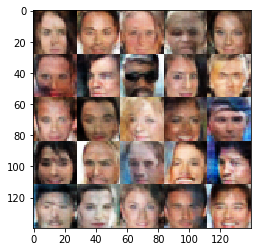

Epoch 6/10 Step 5700... Discriminator Loss: 0.6572... Generator Loss: 1.9887 Time spent: 1.0980
Epoch 6/10 Step 5800... Discriminator Loss: 0.6094... Generator Loss: 2.3141 Time spent: 1.0949


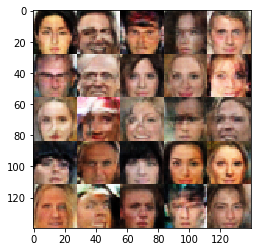

Epoch 6/10 Step 5900... Discriminator Loss: 0.7557... Generator Loss: 1.8483 Time spent: 1.0968
Epoch 6/10 Step 6000... Discriminator Loss: 1.3839... Generator Loss: 0.6218 Time spent: 1.0914


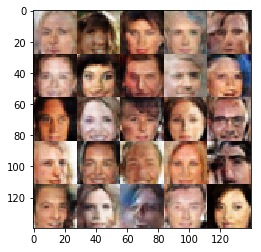

Epoch 7/10 Step 6100... Discriminator Loss: 0.5430... Generator Loss: 2.0402 Time spent: 1.0905
Epoch 7/10 Step 6200... Discriminator Loss: 0.5077... Generator Loss: 2.9641 Time spent: 1.0916


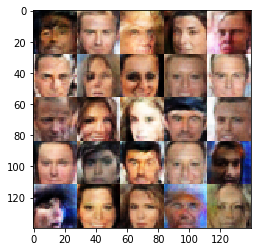

Epoch 7/10 Step 6300... Discriminator Loss: 0.7257... Generator Loss: 1.5557 Time spent: 1.0994
Epoch 7/10 Step 6400... Discriminator Loss: 0.5392... Generator Loss: 2.7148 Time spent: 1.0925


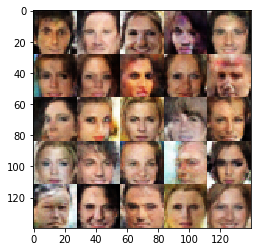

Epoch 7/10 Step 6500... Discriminator Loss: 0.9423... Generator Loss: 1.0106 Time spent: 1.1082
Epoch 7/10 Step 6600... Discriminator Loss: 1.6373... Generator Loss: 0.5328 Time spent: 1.0927


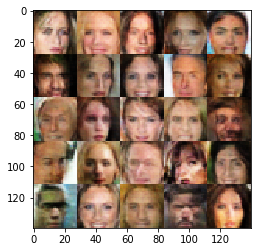

Epoch 7/10 Step 6700... Discriminator Loss: 1.9507... Generator Loss: 4.1815 Time spent: 1.1048
Epoch 7/10 Step 6800... Discriminator Loss: 0.9699... Generator Loss: 1.0346 Time spent: 1.0975


Epoch 7/10 Step 6900... Discriminator Loss: 0.7212... Generator Loss: 1.5139 Time spent: 1.0999
Epoch 7/10 Step 7000... Discriminator Loss: 0.8805... Generator Loss: 1.0741 Time spent: 1.0997


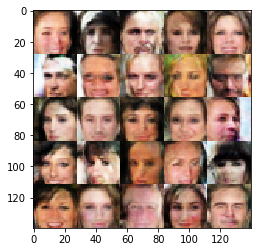

Epoch 8/10 Step 7100... Discriminator Loss: 0.9546... Generator Loss: 0.9940 Time spent: 1.1070
Epoch 8/10 Step 7200... Discriminator Loss: 2.4707... Generator Loss: 0.2311 Time spent: 1.1006


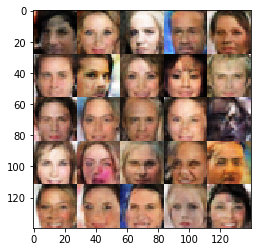

Epoch 8/10 Step 7300... Discriminator Loss: 0.3785... Generator Loss: 4.9413 Time spent: 1.0937
Epoch 8/10 Step 7400... Discriminator Loss: 0.3996... Generator Loss: 3.4654 Time spent: 1.0913


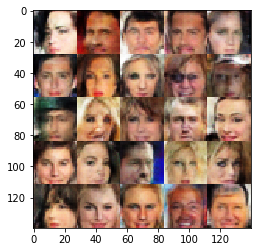

Epoch 8/10 Step 7500... Discriminator Loss: 0.8591... Generator Loss: 1.1629 Time spent: 1.1001
Epoch 8/10 Step 7600... Discriminator Loss: 0.6546... Generator Loss: 1.5546 Time spent: 1.0973


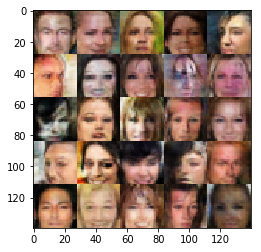

Epoch 8/10 Step 7700... Discriminator Loss: 0.4603... Generator Loss: 2.4892 Time spent: 1.0932
Epoch 8/10 Step 7800... Discriminator Loss: 0.9250... Generator Loss: 1.1280 Time spent: 1.0957


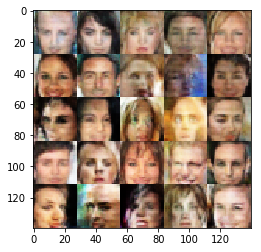

Epoch 8/10 Step 7900... Discriminator Loss: 0.4095... Generator Loss: 3.0488 Time spent: 1.0968
Epoch 8/10 Step 8000... Discriminator Loss: 0.6661... Generator Loss: 2.9309 Time spent: 1.0996


Epoch 9/10 Step 8100... Discriminator Loss: 0.7382... Generator Loss: 1.5038 Time spent: 1.0876
Epoch 9/10 Step 8200... Discriminator Loss: 0.4776... Generator Loss: 2.7112 Time spent: 1.0951


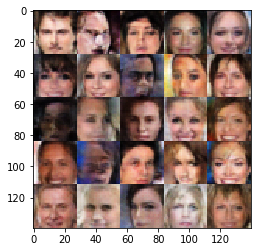

Epoch 9/10 Step 8300... Discriminator Loss: 0.4398... Generator Loss: 2.6122 Time spent: 1.0983
Epoch 9/10 Step 8400... Discriminator Loss: 0.6294... Generator Loss: 1.7415 Time spent: 1.0952


Epoch 9/10 Step 8500... Discriminator Loss: 0.4831... Generator Loss: 2.3144 Time spent: 1.0988
Epoch 9/10 Step 8600... Discriminator Loss: 0.4410... Generator Loss: 2.8532 Time spent: 1.0965


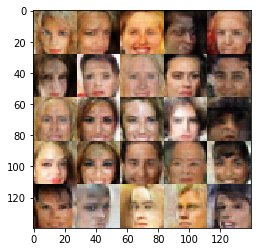

Epoch 9/10 Step 8700... Discriminator Loss: 0.4114... Generator Loss: 3.0085 Time spent: 1.0921
Epoch 9/10 Step 8800... Discriminator Loss: 0.4576... Generator Loss: 2.5736 Time spent: 1.1043


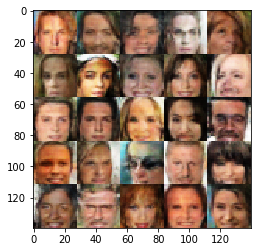

Epoch 9/10 Step 8900... Discriminator Loss: 0.6369... Generator Loss: 1.6291 Time spent: 1.0903
Epoch 9/10 Step 9000... Discriminator Loss: 0.4605... Generator Loss: 2.8076 Time spent: 1.0927


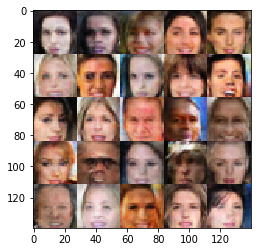

Epoch 9/10 Step 9100... Discriminator Loss: 1.3390... Generator Loss: 0.6558 Time spent: 1.0982
Epoch 10/10 Step 9200... Discriminator Loss: 0.4954... Generator Loss: 2.5967 Time spent: 1.1020


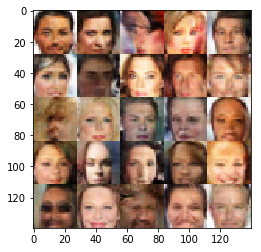

Epoch 10/10 Step 9300... Discriminator Loss: 0.6254... Generator Loss: 1.7034 Time spent: 1.0833
Epoch 10/10 Step 9400... Discriminator Loss: 0.5881... Generator Loss: 2.5088 Time spent: 1.1014


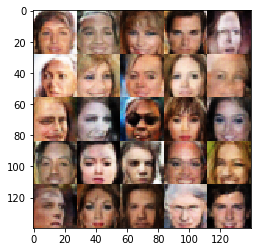

Epoch 10/10 Step 9500... Discriminator Loss: 0.7117... Generator Loss: 2.4781 Time spent: 1.1035
Epoch 10/10 Step 9600... Discriminator Loss: 0.8468... Generator Loss: 2.4868 Time spent: 1.0980


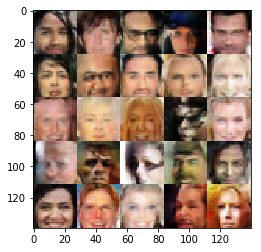

Epoch 10/10 Step 9700... Discriminator Loss: 0.9719... Generator Loss: 1.0727 Time spent: 1.0942
Epoch 10/10 Step 9800... Discriminator Loss: 0.4770... Generator Loss: 2.5907 Time spent: 1.0979


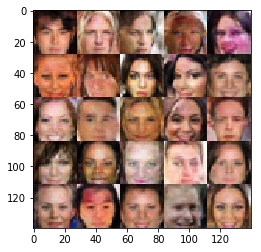

Epoch 10/10 Step 9900... Discriminator Loss: 0.3560... Generator Loss: 5.1690 Time spent: 1.0895
Epoch 10/10 Step 10000... Discriminator Loss: 0.6089... Generator Loss: 1.7011 Time spent: 1.0990


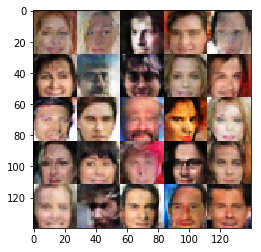

Epoch 10/10 Step 10100... Discriminator Loss: 0.7589... Generator Loss: 1.2934 Time spent: 1.0885
Total Training Time: 9849.3598


In [94]:
batch_size = 200
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

alpha = 0.2
drop_rate = 0.5
size_mult = 128
smooth = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
                   celeba_dataset.shape, celeba_dataset.image_mode, 
                   alpha=alpha, drop_rate=drop_rate, size_mult=size_mult, smooth=smooth)

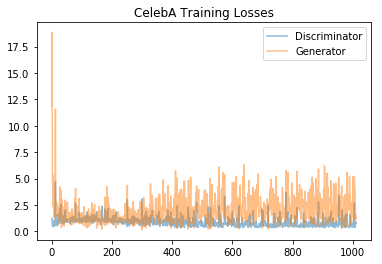

In [95]:
fig, ax = pyplot.subplots()
losses = np.array(losses)
pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
pyplot.title("CelebA Training Losses")
pyplot.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.